In [1]:
%matplotlib inline

In [2]:
#-------------------------------------------------------------------------------------------------------------------------------
# By Alexandra Lee (July 2018) 
#
# Generate input files
#
# Dataset: Pseudomonas aeruginosa gene expression compendium referenced in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5069748/
# 
# Use map_file to group samples into phenotype groups (condition A and B) based on experimental design annotations
# Example: control vs treatment with antibiotics
# 
# Then group samples into training and test sets
#
# Generate offset vector using gene expression data in the original space (train_offset_original):
# average gene expression for condition A - average gene expression for condition B using all genes/dimensions
#-------------------------------------------------------------------------------------------------------------------------------
import os
import pandas as pd
import numpy as np
from scipy.stats import variation
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(123)

In [3]:
# load arguments
#data_file = '/home/alexandra/Documents/Pseudomonas_scratch/all-pseudomonas-gene-normalized.pcl'
data_file = os.path.join(os.path.dirname(os.getcwd()), "data", "all-pseudomonas-gene-normalized.zip")  # repo file is zipped
map_file = os.path.join(os.path.dirname(os.getcwd()), "metadata", "mapping_cipro.txt")

In [4]:
# read in data
data = pd.read_table(data_file, header = 0, sep = '\t', index_col = 0, compression='zip')
X = data.transpose()
X.head(5)

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
0.1_12hr_CSV86(Pae_G1a).CEL,0.472897,0.396658,0.253776,0.000000,0.175640,0.554385,0.411370,0.382222,0.310144,0.642522,...,0.358597,0.390048,0.457406,0.684082,0.338351,0.608325,0.643496,0.276075,0.112773,0.145170
0.1_2hr_CSV86(Pae_G1a).CEL,0.262346,0.086216,0.359853,0.439214,0.269749,0.768433,0.212505,0.062043,0.567695,0.467073,...,0.358504,0.414206,0.389879,0.477693,0.000000,0.479385,0.154471,0.140891,0.167505,0.157060
0.1_6hr_CSV86(Pae_G1a).CEL,0.473658,0.244862,0.330750,0.097697,0.387226,0.328319,0.228820,0.330039,0.318081,0.512864,...,0.180744,0.380741,0.173501,0.251571,0.182793,0.528301,0.504985,0.499782,0.061106,0.365612
0.1_7hr_CSV86(Pae_G1a).CEL,0.439273,0.343402,0.192698,0.274677,0.628979,0.553796,0.431391,0.363480,0.385721,0.094584,...,0.346837,0.153927,0.067349,0.319723,0.282442,0.490655,0.531415,0.153880,0.132333,0.260087
0.1_9hr_CSV86(Pae_G1a).CEL,0.220827,0.145525,0.437803,0.293201,0.635120,0.462893,0.488733,0.309584,0.318646,0.591914,...,0.237726,0.301945,0.070222,0.513605,0.114277,0.360259,0.386868,0.223995,0.105343,0.102088


In [5]:
# read in metadata file containing grouping of each sample into training/test and phenotypic group
grp = pd.read_table(map_file, header = 0, sep = '\t', index_col = None)
grp

,Experiment ID,Sample ID,Group
0,E-GEOD-47173,GSM1146022_pJN105_1.CEL,control
1,E-GEOD-47173,GSM1146023_pJN105_2.CEL,control
2,E-GEOD-33871,GSM838212_PAO1-LB-1_Pae_G1a.CEL,control
3,E-GEOD-33871,GSM838213_PAO1-LB-2_Pae_G1a.CEL,control
4,E-GEOD-33871,GSM838214_PAO1-LB-3_Pae_G1a.CEL,control
5,E-GEOD-39044,GSM954576_Nomura_PA01-1_Pae_G1a_.CEL,control
6,E-GEOD-39044,GSM954577_Nomura_PA01-2_Pae_G1a_.CEL,control
7,E-GEOD-39044,GSM954578_Nomura_PA01-3_Pae_G1a_.CEL,control
8,E-GEOD-39044,GSM954579_Nomura_PA01-4_Pae_G1a_.CEL,control
9,E-GEOD-33244,GSM822708_wtLB_A.CEL,control


In [6]:
# Group samples into condition A and B based on mapping file provided
control_all = pd.DataFrame()
treat_all = pd.DataFrame()

for index, row in grp.iterrows():
    if row['Group'] == 'control':
        sample = str(row['Sample ID'])
        control_all = control_all.append(X[X.index.str.contains(sample, regex=False)])
        #print('Training group A {}'.format(sample))
    else:
        sample = str(row['Sample ID'])
        treat_all = treat_all.append(X[X.index.str.contains(sample, regex=False)])
        #print('Training group B {}'.format(sample))

# Split 10% test set randomly
test_set_percent = 0.2
test_control = control_all.sample(frac=test_set_percent)
train_control = control_all.drop(test_control.index)

test_treat = treat_all.sample(frac=test_set_percent)
train_treat = treat_all.drop(test_treat.index)

#control_all
#train_treat
#test_treat

0.99574779917987377

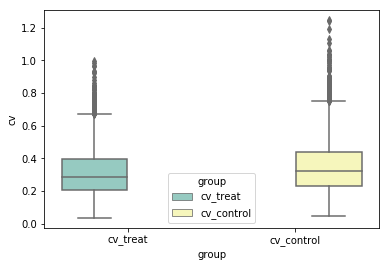

In [13]:
# Calculate Coefficient of Variance (CV) to determine variance between samples
# CV is the standardized measure of dispersion from the mean
treat_cv = variation(treat_all, axis = 0)
treat_cv = pd.DataFrame(treat_cv, columns = ['cv_treat'])
treat_cv.insert(0, 'gene_id', treat_all.columns)

control_cv = variation(control_all, axis = 0)
control_cv = pd.DataFrame(control_cv, columns = ['cv_control'])
control_cv.insert(0, 'gene_id', control_all.columns)

# Join 
CV = pd.merge(treat_cv, control_cv, on = 'gene_id')
CV = pd.melt(CV, id_vars = 'gene_id', var_name = 'group', value_name = 'cv' )
CV.head(5)

# figure
fig = plt.figure()
fg = sns.boxplot(x = 'group', y='cv', hue='group',  data=CV, palette="Set3")

In [8]:
# Create input holding out test test
input_holdout = X.drop(test_control.index)
input_holdout = input_holdout.drop(test_treat.index)

input_holdout.head(5)
input_holdout.shape
#X.shape

(1183, 5549)

In [9]:
# Average gene expression across samples in training set
train_control_mean = train_control.mean(axis=0)
train_treat_mean = train_treat.mean(axis=0)

# Generate offset using average gene expression in original dataset
train_offset_original = train_treat_mean - train_control_mean

In [10]:
# Output training and test sets
fig_file = os.path.join(os.path.dirname(os.getcwd()), "viz", "cv.png")
fig.savefig(fig_file)

#train_control.to_csv(os.path.join(os.path.dirname(os.getcwd()), "data", "train_control.txt"), sep='\t')
#train_treat.to_csv(os.path.join(os.path.dirname(os.getcwd()), "data", "train_treat.txt"), sep='\t')

#test_control.to_csv(os.path.join(os.path.dirname(os.getcwd()), "data", "test_control.txt"), sep='\t')
#test_treat.to_csv(os.path.join(os.path.dirname(os.getcwd()), "data", "test_treat.txt"), sep='\t')

#train_offset_original.to_csv(os.path.join(os.path.dirname(os.getcwd()), "data", "train_offset_original.txt"), sep='\t')
#input_holdout.to_csv(os.path.join(os.path.dirname(os.getcwd()), "data", "train_model_input.txt.xz"), sep='\t', compression='xz')